Sample Code from Udemy GNN course

<div align="center">
<h1>Simple Graph Convolution classification for Cora data</h1>
    <img src="https://production-media.paperswithcode.com/datasets/Cora-0000000700-ce1c5ec7_LD7pZnT.jpg" width=500>
</div>

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00


In [2]:
import torch
from torch_geometric.datasets import Planetoid # The citation network datasets “Cora”, “CiteSeer” and “PubMed”
from torch_geometric.nn import SGConv # Import Node2Vec Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Importing Data

In [3]:
path = "./input"  # Directory to download dataset
dataset = Planetoid(path, "Cora") # Download the dataset
data = dataset[0] # Tensor representation of the Cora-Planetoid data
print('Cora: ', data)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Processing...


Cora:  Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Done!


# Node2Vec Model Construction

In [4]:
SGC_model = SGConv(in_channels= data.num_features, # Number of features
                   out_channels= dataset.num_classes, # Dimension of embedding
                   K = 1, cached =True)
print(" Shape of the original data: ", data.x.shape)
print(" Shape of the embedding data: ", SGC_model(data.x,data.edge_index).shape)

 Shape of the original data:  torch.Size([2708, 1433])
 Shape of the embedding data:  torch.Size([2708, 7])


# Embedding Visualization with T-SNE

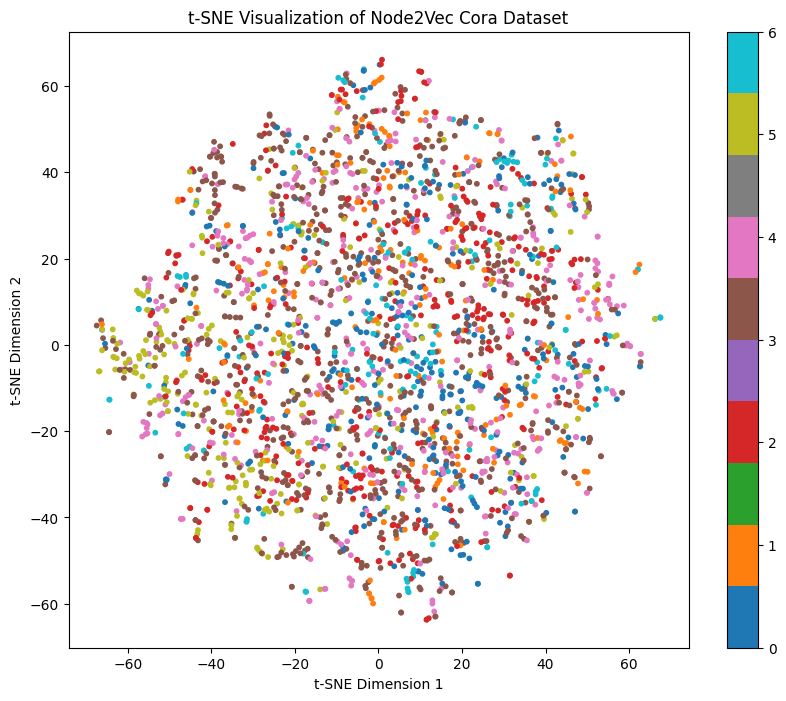

In [5]:
# Get node embeddings
embeddings = SGC_model(data.x, data.edge_index).detach().cpu().numpy()

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2)  # Change n_components to 3 for 3D visualization
embedding_tsne = tsne.fit_transform(embeddings)


# Plot the nodes
plt.figure(figsize=(10, 8))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=data.y, cmap='tab10', s=10)
plt.title('t-SNE Visualization of Node2Vec Cora Dataset')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar()
plt.show()

# SGNet Classification Model

In [6]:
class SGCNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SGConv(in_channels= data.num_features, # Number of features
                   out_channels= dataset.num_classes, # Dimension of embedding
                   K = 1, cached =True)

    def forward(self):
        x = self.conv1(data.x,  data.edge_index) #Applying convolution to data

        # computation of log softmax
        return F.log_softmax(x, dim=1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SGC_model, data = SGCNet().to(device), data.to(device)
optimizer = torch.optim.Adam(SGC_model.parameters(), lr=0.2, weight_decay=0.005)

# What are the learning parameters:
for i, parameter in SGC_model.named_parameters():
    print(" Parameter {}".format(i))
    print("Shape: ",parameter.shape)

 Parameter conv1.lin.weight
Shape:  torch.Size([7, 1433])
 Parameter conv1.lin.bias
Shape:  torch.Size([7])


# Train and Test functions

In [7]:
def train():
    SGC_model.train() # Set the model.training to be True
    optimizer.zero_grad() # Reset the gradient
    predicted_y = SGC_model() # predicted y in log softmax prob
    true_y = data.y # True labels
    losses = F.nll_loss(predicted_y[data.train_mask], true_y[data.train_mask])
    losses.backward()
    optimizer.step() # Update the parameters such that is minimized the losses


def test():
    SGC_model.eval() # Set the model.training to be False
    logits = SGC_model() # Log prob of all data
    accs = []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1] #Transforming log prob to actual labels
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

# Application

Epoch: 001, Train: 0.9714, Val: 0.5360, Test: 0.5730
Epoch: 002, Train: 0.9929, Val: 0.7480, Test: 0.7610
Epoch: 003, Train: 0.9929, Val: 0.7540, Test: 0.7640
Epoch: 004, Train: 1.0000, Val: 0.7540, Test: 0.7640
Epoch: 005, Train: 0.9929, Val: 0.7540, Test: 0.7640
Epoch: 006, Train: 0.9929, Val: 0.7540, Test: 0.7640
Epoch: 007, Train: 1.0000, Val: 0.7540, Test: 0.7640
Epoch: 008, Train: 1.0000, Val: 0.7540, Test: 0.7640
Epoch: 009, Train: 1.0000, Val: 0.7540, Test: 0.7640
Epoch: 010, Train: 1.0000, Val: 0.7540, Test: 0.7640
Epoch: 011, Train: 1.0000, Val: 0.7540, Test: 0.7640
Epoch: 012, Train: 1.0000, Val: 0.7540, Test: 0.7640
Epoch: 013, Train: 1.0000, Val: 0.7560, Test: 0.7800
Epoch: 014, Train: 1.0000, Val: 0.7560, Test: 0.7800
Epoch: 015, Train: 1.0000, Val: 0.7560, Test: 0.7800
Epoch: 016, Train: 1.0000, Val: 0.7560, Test: 0.7800
Epoch: 017, Train: 1.0000, Val: 0.7560, Test: 0.7800
Epoch: 018, Train: 1.0000, Val: 0.7560, Test: 0.7800
Epoch: 019, Train: 1.0000, Val: 0.7560, Test: 

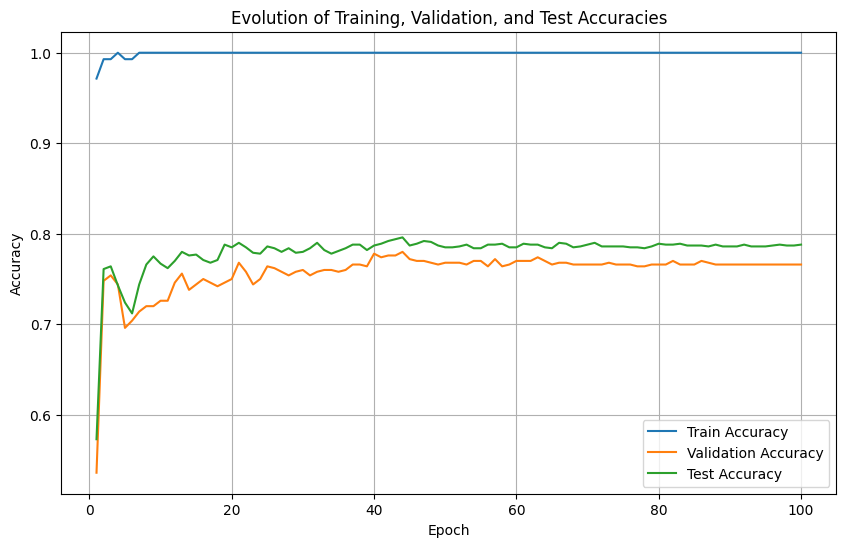

In [8]:

# Initialize lists to store accuracies
train_accs = []
val_accs = []
test_accs = []

best_val_acc = test_acc = 0

for epoch in range(1, 101):
    train()
    train_acc, val_acc, tmp_test_acc = test()
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    test_accs.append(tmp_test_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, train_acc, best_val_acc, test_acc))

# Plot the evolution of accuracies
plt.figure(figsize=(10, 6))
epochs = range(1, 101)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolution of Training, Validation, and Test Accuracies')
plt.legend()
plt.grid(True)
plt.show()
